In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
%config Completer.use_jedi = False


In [2]:
ds = pd.read_feather('../data/train_for_test.ftr')

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646297 entries, 0 to 3646296
Data columns (total 5 columns):
date_block_num    category
shop_id           category
item_id           category
item_cnt_month    float64
item_price        float64
dtypes: category(3), float64(2)
memory usage: 70.3 MB


In [4]:
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras import optimizers


Using TensorFlow backend.


In [5]:
def make_year(block):
    return np.int(2014+np.floor(block/12))

def make_month(block):
    return (1+np.mod(block,12))

In [6]:
ds['year']=ds.date_block_num.apply(make_year).astype('category')
ds['month']=ds.date_block_num.apply(make_month).astype('category')

ds.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,year,month
0,0,2,30,0.0,NaN,2014,1
1,0,2,31,0.0,NaN,2014,1
2,0,2,32,0.0,NaN,2014,1
3,0,2,33,1.0,499.0,2014,1
4,0,2,53,0.0,NaN,2014,1


In [7]:
embedding_columns=ds.select_dtypes(include='category').columns
embedding_columns=embedding_columns.drop('date_block_num')
embedding_columns

Index(['shop_id', 'item_id', 'year', 'month'], dtype='object')

In [8]:
for c in embedding_columns:
    ds[c].cat.remove_unused_categories(inplace=True)

In [9]:
n_levels = ds[embedding_columns].nunique()
n_levels

shop_id      42
item_id    4716
year          3
month        12
dtype: int64

In [10]:
ds[embedding_columns].max()

shop_id       59.0
item_id    22167.0
year        2016.0
month         12.0
dtype: float64

In [11]:
n_dimensions=n_levels.copy()
n_dimensions.iloc[range(4)]=[20,50,2,6]
n_dimensions

shop_id    20
item_id    50
year        2
month       6
dtype: int64

In [12]:
'''
input_block = Input(shape=(1,))
output_block = Embedding(n_levels.date_block_num, n_dimensions.date_block_num, name='block_embedding')(input_block)
output_block = Reshape(target_shape=(n_dimensions.date_block_num,))(output_block)
'''

"\ninput_block = Input(shape=(1,))\noutput_block = Embedding(n_levels.date_block_num, n_dimensions.date_block_num, name='block_embedding')(input_block)\noutput_block = Reshape(target_shape=(n_dimensions.date_block_num,))(output_block)\n"

In [13]:
input_shop = Input(shape=(1,))
output_shop = Embedding(n_levels.shop_id, n_dimensions.shop_id, name='shop_embedding')(input_shop)
output_shop = Reshape(target_shape=(n_dimensions.shop_id,))(output_shop)


In [14]:
input_item = Input(shape=(1,))
output_item = Embedding(n_levels.item_id, n_dimensions.item_id, name='item_embedding')(input_item)
output_item = Reshape(target_shape=(n_dimensions.item_id,))(output_item)


In [15]:
input_year = Input(shape=(1,))
output_year = Embedding(n_levels.year, n_dimensions.year, name='year_embedding')(input_year)
output_year = Reshape(target_shape=(n_dimensions.year,))(output_year)



In [16]:
input_month = Input(shape=(1,))
output_month = Embedding(n_levels.month, n_dimensions.month, name='month_embedding')(input_month)
output_month = Reshape(target_shape=(n_dimensions.month,))(output_month)



In [17]:
#input_model = [input_block, input_shop ,input_item ]
#output_embeddings = [output_block,output_shop,output_item]

input_model = [input_shop ,input_item ,input_year,input_month]
output_embeddings = [output_shop,output_item,output_year,output_month]

In [18]:
output_model = Concatenate()(output_embeddings)
output_model = Dense(200, kernel_initializer="uniform")(output_model)
output_model = Dropout(0.02)(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(50, kernel_initializer="uniform")(output_model)
output_model = Dropout(0.01)(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(1)(output_model)
output_model = Activation('relu')(output_model)
#output_model = Activation('sigmoid')(output_model)

model = KerasModel(inputs=input_model, outputs=output_model)

In [19]:
dsmall=ds#.sample(n=1*10**5)
x=list(dsmall[embedding_columns].values.T)
#x=[dsmall.date_block_num.cat.codes.values,dsmall.shop_id.cat.codes.values,dsmall.item_id.cat.codes.values]
x=[dsmall[c].cat.codes.values for c in embedding_columns]


y=dsmall.item_cnt_month.clip(lower=0,upper=20)

In [20]:
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [21]:
model.fit(x,y,validation_split=0.3,epochs=5,verbose=1,batch_size=2048)

Train on 2552407 samples, validate on 1093890 samples
Epoch 1/5
2552407/2552407 [==============================] - 45s 18us/step - loss: 1.7807 - val_loss: 1.3471
Epoch 2/5
2552407/2552407 [==============================] - 44s 17us/step - loss: 1.2933 - val_loss: 1.2599
Epoch 3/5
2552407/2552407 [==============================] - 44s 17us/step - loss: 1.0111 - val_loss: 1.1769
Epoch 4/5
2552407/2552407 [==============================] - 44s 17us/step - loss: 0.8701 - val_loss: 1.2501
Epoch 5/5
2552407/2552407 [==============================] - 45s 17us/step - loss: 0.7993 - val_loss: 1.2755


In [76]:
test=pd.read_csv('../readonly/final_project_data/test.csv')

In [77]:
test['year']=2016
test['month']=11

for c in embedding_columns:
    test[c]=test[c].astype('category')
    test[c].cat.set_categories(ds[c].cat.categories,inplace=True)



In [78]:
test.head()

,ID,shop_id,item_id,year,month
0,0,5,5037.0,2016,11
1,1,5,NaN,2016,11
2,2,5,5233.0,2016,11
3,3,5,5232.0,2016,11
4,4,5,NaN,2016,11


In [90]:
x_test=[test.dropna()[c].cat.codes.values for c in embedding_columns]

x_test

[array([ 3,  3,  3, ..., 29, 29, 29], dtype=int8),
 array([1105, 1147, 1146, ..., 3435, 4244,  144], dtype=int16),
 array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
 array([10, 10, 10, ..., 10, 10, 10], dtype=int8)]

In [91]:
y_test=model.predict(x_test)

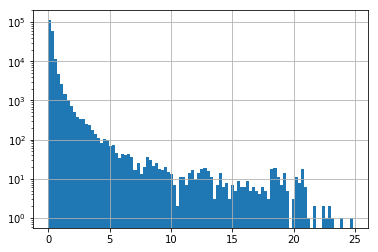

In [92]:
ds_y_test=pd.Series(np.array(y_test)[:,0])
ds_y_test.hist(bins=100,log=True)

In [93]:
ds_y_test.clip_upper(20).mean()

0.3717523217201233

In [96]:
len(y_test),test.item_id.notna().sum()

(198072, 198072)

In [101]:
test['item_cnt_month']=0.25
test.loc[test.item_id.notna(),'item_cnt_month']=y_test
test.item_cnt_month.clip(lower=0,upper=20,inplace=True)

In [102]:
test[['ID','item_cnt_month']].to_csv('../data/submission_model22.csv',index=False)

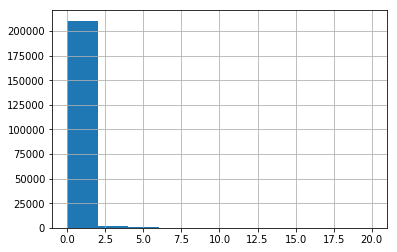

In [104]:
test.item_cnt_month.hist()

In [155]:
ds['item_cnt_month_lag_1'] = ds.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(1)
ds['item_cnt_month_lag_2'] = ds.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(2)



In [156]:
ds_last_prev=ds.loc[ds.date_block_num==33,['shop_id','item_id','item_cnt_month_lag_2']]
ds_prev=ds.loc[ds.date_block_num==31,['shop_id','item_id','item_cnt_month']]

In [157]:
ds_compare=pd.merge(ds_last_prev,ds_prev,on=['shop_id','item_id'])

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [168]:
(ds_compare.item_cnt_month-ds_compare.item_cnt_month_lag_2).abs().max()

0.0

In [169]:
ds.isna().sum()

date_block_num                0
shop_id                       0
item_id                       0
item_cnt_month                0
item_price              3046168
year                          0
month                         0
item_cnt_month_lag.1     111403
item_cnt_month_lag_1     111403
item_cnt_month_lag_2     222554
dtype: int64